Use SocialGNN_encoding_2 environment

In [14]:
import os
from tqdm import tqdm
import pickle
import numpy as np
import pandas as pd

from sklearn.linear_model import RidgeCV, Ridge
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
import gc

import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
options = ['LSTM', 'SocialGNN', 'LSTM_Relation']
model_selection = input(f'Which model would you like to use? {", ".join(options)}: ')
if model_selection not in options:
    raise ValueError(f'Model selection must be in {options}')
model_encoding_dir = f'Data/layer_representations/{model_selection}'
layer_options = os.listdir(model_encoding_dir)
layer_selection= []
while True:
    selection = input(f'Which layer would you like to use? {", ".join(layer_options)}: ')
    if selection not in layer_options:
        raise ValueError(f'Layer selection must be in {layer_options}') 
    if selection not in layer_selection:
        layer_selection.append(selection)
    if input(f'Would you like to add more layer? (y/n): ') == 'n':
        break

In [16]:
target_ratings_dir = 'Data/behavioral_ratings.csv'
ratings_of_interest =['expanse', 'transitivity','agent distance', 'facingness', 'communication',  'joint action', 'valence', 'arousal']

In [17]:
def load_pickle(path):
    with open(path, 'rb') as f:
        pickled = pickle.load(f)
    return pickled

In [18]:
ratings_df = pd.read_csv(target_ratings_dir)[['video_name'] + ratings_of_interest]
ratings_df_sorted = ratings_df.sort_values(by='video_name')

In [19]:
''' Function for you to test out the encoding results of a single layer from a selected model
    Input: X - a numpy array of loaded pickle file (n_samples=250, n_features)
    Example Usage: 
    model_features = load_pickle('Data/layer_representations/SocialGNN/final_state/GazeDataset_Jun1523_traintest5Jun23_2_0_SocialGNN_V_5_5_12_12_6_2_20_1.0_1.5_0.001_0.01')
    X = np.vstack(model_features)
'''

def single_layer_encoding(X):
    results = {}
    for rating in ratings_of_interest:
        y = ratings_df_sorted[rating].values
    
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
        # Initialize the Ridge regression model
        ridge = Ridge(alpha=1.0)
    
        # Fit the model on the training data
        ridge.fit(X_train, y_train)
    
        # Predict on the test data
        y_pred = ridge.predict(X_test)
    
        # Calculate Mean Squared Error
        mse = mean_squared_error(y_test, y_pred)
        results[rating] = mse
        print(f'Mean Squared Error for {rating}: {mse}')

In [20]:
def ridge_regression_benchmarking(target, layers, models,
                                  n_splits=4, random_seed=0, alphas=None):
    # if alphas is None:
    #     alphas = [10.**power for power in np.arange(-5, 2)]
    
    all_model_results = []
    
    # Iterate over each target rating separately
    for target_idx in tqdm(range(target.shape[1])):  # Assuming target is a 2D array
        current_target = target[:, target_idx]
        
        # Extract layer representations using TensorFlow
        for layer in layers:
            layer_path = os.path.join(model_encoding_dir, layer)
            for model_name in models:
                model_path = os.path.join(layer_path, model_name)
                layer_representation = np.vstack(load_pickle(model_path))
        
                # Initialize KFold
                cv = KFold(n_splits=n_splits, shuffle=True, random_state=random_seed)
                
                # Flatten the representation if necessary
                X = layer_representation.reshape(layer_representation.shape[0], -1)
                    
                # Split data into train/test indices
                for train_idx, test_idx in cv.split(X):
                    # Separate train/test data and target values
                    X_train, X_test = X[train_idx], X[test_idx]
                    y_train, y_test = current_target[train_idx], current_target[test_idx]
        
                    # Initialize RidgeCV model
                    ridge = RidgeCV(
                        # alphas=alphas
                        )
                    
                    # Perform cross-validation
                    train_scores = []
                    for inner_train_idx, val_idx in cv.split(X_train):
                        ridge.fit(X_train[inner_train_idx], y_train[inner_train_idx])
                        train_scores.append(ridge.score(X_train[val_idx], y_train[val_idx]))
            
                    # Fit on full train set and evaluate on test set
                    ridge.fit(X_train, y_train)
                    test_score = ridge.score(X_test, y_test)
                        
                    # Store results for this target
                    all_model_results.append({
                        'target': ratings_of_interest[target_idx],
                        'train_score': np.mean(train_scores),
                        'test_score': test_score,
                        'layer': layer,
                        'model_name': model_name
                    })
                    
                    # Memory cleanup
                    gc.collect()


    return pd.DataFrame(all_model_results)


In [21]:
target = ratings_df_sorted[ratings_of_interest].values
layer_representations_dirs = []
for layer in layer_selection:
    layer_encoding_dir = os.path.join(model_encoding_dir, layer)
    layer_representations_dirs += [i for i in os.listdir(layer_encoding_dir)]
len(layer_representations_dirs)

40

In [22]:
results = ridge_regression_benchmarking(target, layer_selection, layer_representations_dirs)
results

100%|██████████| 8/8 [01:22<00:00, 10.27s/it]


,target,train_score,test_score,layer,model_name
0,expanse,0.013051,0.137948,final_state,GazeDataset_Jun1523_traintest14Jun23_2_0_CueBa...
1,expanse,0.018258,0.000585,final_state,GazeDataset_Jun1523_traintest14Jun23_2_0_CueBa...
2,expanse,0.002105,-0.065848,final_state,GazeDataset_Jun1523_traintest14Jun23_2_0_CueBa...
3,expanse,0.009682,0.089130,final_state,GazeDataset_Jun1523_traintest14Jun23_2_0_CueBa...
4,expanse,-0.060131,0.036779,final_state,GazeDataset_Jun1523_traintest14Jun23_2_1_CueBa...
...,...,...,...,...,...
1275,arousal,-0.028926,-0.092814,final_state,GazeDataset_Jun1523_traintest5Jun23_5_8_CueBas...
1276,arousal,-0.003674,0.039854,final_state,GazeDataset_Jun1523_traintest5Jun23_5_9_CueBas...
1277,arousal,-0.025329,-0.030925,final_state,GazeDataset_Jun1523_traintest5Jun23_5_9_CueBas...
1278,arousal,-0.027074,0.016143,final_state,GazeDataset_Jun1523_traintest5Jun23_5_9_CueBas...


In [23]:
x_labels = ['spatial expanse', 'object directed', 'interagent distance', 'agents facing', 'communicating', 'acting jointly', 'valence', 'arousal']


# Assuming 'results_df' is the DataFrame returned by ridge_regression_benchmarking function
def plot_ridge_regression_results(results_df, title):
    plt.figure(figsize=(10, 6))
    
    
    # Plot each target's test score as a scatter plot
    sns.stripplot(x='target', y='test_score', data=results_df, jitter=True, dodge=True)
    
    # Plot median bars
    # sns.pointplot(data = results_df, x="target", y="test_score", linestyles='none', estimator=np.median, color='red', markers='_', errorbar=None, dodge=0.4,markeredgewid)

    
    plt.title('Test Scores by Target Rating')
    plt.xlabel('Target Rating')
    plt.ylabel('Test Score (r)')
    plt.ylim(-0.25, 1)
    plt.xticks(ticks=range(len(x_labels)), labels=x_labels, rotation = 20)
    plt.grid(False)
    plt.savefig(f'result_figures/behavioral_encoding/{title}.png')
    plt.show()

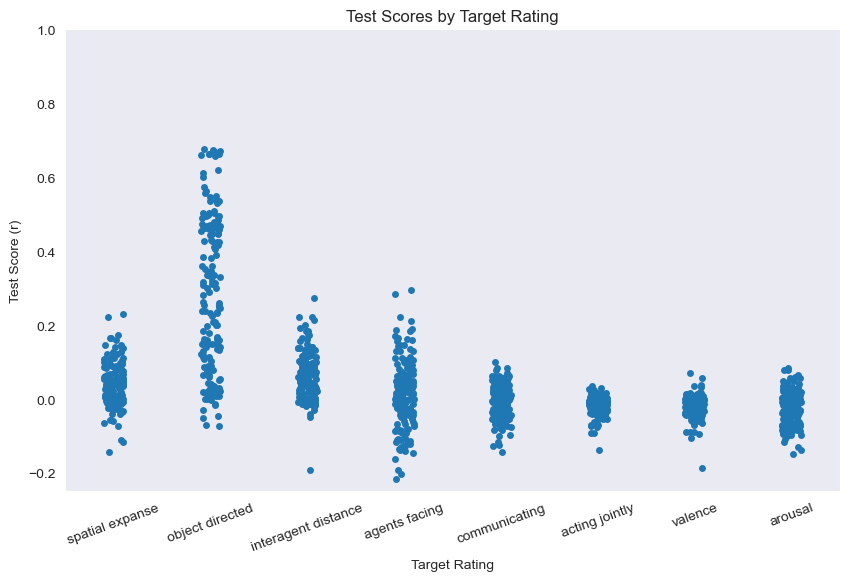

In [24]:
plot_ridge_regression_results(results, f'ridge-{model_selection}-{"-".join(layer_selection)}')